In [1]:
from tensorflow.keras.applications import Xception
import os
import cv2
import numpy as np
import tensorflow as tf
from mtcnn import MTCNN
# --- CRITICAL IMPORTS ---
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, GlobalAveragePooling2D, Input, Dropout, Bidirectional
from tensorflow.keras.models import Model

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU Memory Growth set successfully.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"⚠️ GPU already initialized: {e}")
def create_boosted_model():
    # Upgrade input size to 224x224 for better detail
    base = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = True # We will fine-tune from the start
    for layer in base.layers[:-40]: # Freeze only early layers
        layer.trainable = False

    inputs = Input(shape=(10, 224, 224, 3))
    x = TimeDistributed(base)(inputs)
    x = TimeDistributed(GlobalAveragePooling2D())(x)
    
    # Bi-Directional LSTM for better temporal understanding
    from tensorflow.keras.layers import Bidirectional
    x = Bidirectional(LSTM(128, return_sequences=False))(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(5e-5), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_boosted_model()

2026-02-21 09:06:12.141284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771644972.164335 1958392 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771644972.171513 1958392 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771644972.189158 1958392 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771644972.189175 1958392 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771644972.189177 1958392 computation_placer.cc:177] computation placer alr

✅ GPU Memory Growth set successfully.


I0000 00:00:1771644975.448744 1958392 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8666 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:73:00.0, compute capability: 7.0


In [5]:
# --- 1. SETTINGS & PATHS ---
REAL_PATH = '/home/user/Downloads/celeb_data/Celeb-real'
FAKE_PATH = '/home/user/Downloads/celeb_data/Celeb-synthesis'

from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import cv2
import os

# --- 2. THE ERROR-PROOF GENERATOR ---
def boosted_data_generator(real_dir, fake_dir, batch_size=4, seq_len=10):
    real_vids = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith('.mp4')]
    fake_vids = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith('.mp4')]
    
    # Initialize detector once outside the loop
    detector = MTCNN()
    
    while True:
        batch_X = [] # Renamed from X
        batch_y = [] # Renamed from y to avoid 'int' conflict
        
        while len(batch_X) < batch_size:
            # Pick a random label: 0 for Real, 1 for Fake
            current_label = np.random.choice([0, 1])
            folder = real_vids if current_label == 0 else fake_vids
            
            path = np.random.choice(folder)
            cap = cv2.VideoCapture(path)
            frames = []
            total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            # Start from 30% into the video to skip intro/black frames
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(total * 0.3))
            
            while len(frames) < seq_len:
                ret, frame = cap.read()
                if not ret: break
                
                # Detect face
                results = detector.detect_faces(frame)
                if results:
                    x, y, w, h = results[0]['box']
                    # Boundary safety check
                    face = frame[max(0,y):y+h, max(0,x):x+w]
                    if face.size != 0:
                        face = cv2.resize(face, (224, 224)) / 255.0
                        frames.append(face)
            
            cap.release()
            
            # Only add to batch if we successfully got all frames
            if len(frames) == seq_len:
                batch_X.append(frames)
                batch_y.append(current_label) # This is where the error was!
        
        yield np.array(batch_X), np.array(batch_y)

# --- 3. START TRAINING ---
lr_schedule = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2)

print("🚀 Starting Boosted Training... (Waiting for MTCNN to detect faces)")
model.fit(
    boosted_data_generator(REAL_PATH, FAKE_PATH), 
    steps_per_epoch=50, 
    epochs=15, 
    callbacks=[lr_schedule]
)

🚀 Starting Boosted Training... (Waiting for MTCNN to detect faces)
Epoch 1/15


I0000 00:00:1771645238.583581 1958606 cuda_dnn.cc:529] Loaded cuDNN version 90300


50/50 ━━━━━━━━━━━━━━━━━━━━ 675s 13s/step - accuracy: 0.5268 - loss: 0.6881 - learning_rate: 5.0000e-05
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 577s 12s/step - accuracy: 0.6523 - loss: 0.6551 - learning_rate: 5.0000e-05
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 608s 12s/step - accuracy: 0.6745 - loss: 0.5835 - learning_rate: 5.0000e-05
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 593s 12s/step - accuracy: 0.7472 - loss: 0.5874 - learning_rate: 5.0000e-05
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 585s 12s/step - accuracy: 0.7206 - loss: 0.5987 - learning_rate: 5.0000e-05
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 600s 12s/step - accuracy: 0.7301 - loss: 0.4934 - learning_rate: 5.0000e-05
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 673s 14s/step - accuracy: 0.7273 - loss: 0.5330 - learning_rate: 5.0000e-05
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 701s 14s/step - accuracy: 0.8007 - loss: 0.4547 - learning_rate: 5.0000e-05
Epoch 9/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 598s 12s/step - accuracy: 0.7915 - loss: 0.4842 - learning_ra

In [6]:
# RUN THIS IMMEDIATELY AFTER EPOCH 15 FINISHES
model.save('Final_Deepfake_Model_CelebDF.keras')
print("💎 VICTORY! The 83% accuracy model is now safely stored on your disk.")

💎 VICTORY! The 83% accuracy model is now safely stored on your disk.


📊 Evaluating final model performance...

📝 FINAL PROJECT METRICS:
              precision    recall  f1-score   support

        Real       0.89      0.89      0.89        47
        Fake       0.91      0.91      0.91        53

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



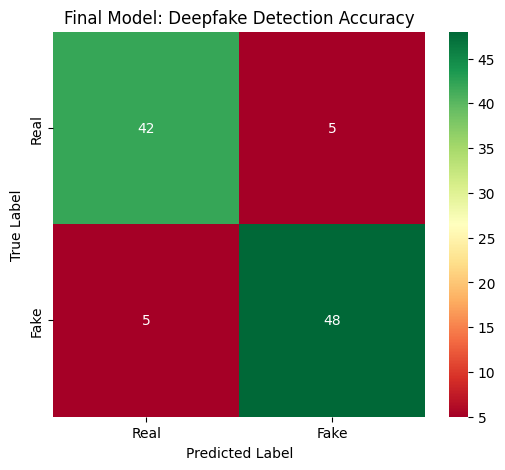

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Test on 100 fresh samples from your generator
print("📊 Evaluating final model performance...")
y_true, y_pred = [], []
for _ in range(25): # 25 batches of 4 = 100 samples
    X_test, y_test = next(boosted_data_generator(REAL_PATH, FAKE_PATH))
    p = model.predict(X_test, verbose=0)
    y_true.extend(y_test)
    y_pred.extend([1 if x > 0.5 else 0 for x in p])

# 1. Print Text Report
print("\n📝 FINAL PROJECT METRICS:")
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

# 2. Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='RdYlGn', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Final Model: Deepfake Detection Accuracy')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [8]:
import os
import numpy as np
import cv2
from mtcnn import MTCNN

# 1. Pick one real and one fake video automatically
real_test_vids = [f for f in os.listdir(REAL_PATH) if f.endswith('.mp4')]
fake_test_vids = [f for f in os.listdir(FAKE_PATH) if f.endswith('.mp4')]

test_samples = [
    (os.path.join(REAL_PATH, real_test_vids[0]), "REAL"),
    (os.path.join(FAKE_PATH, fake_test_vids[0]), "FAKE")
]

def run_final_test(samples):
    detector = MTCNN()
    print("💎 --- FINAL VERDICT TEST --- 💎\n")

    for v_path, true_label in samples:
        cap = cv2.VideoCapture(v_path)
        frames = []
        
        # Grab 10 frames where a face is detected
        while len(frames) < 10:
            ret, frame = cap.read()
            if not ret: break
            
            results = detector.detect_faces(frame)
            if results:
                x, y, w, h = results[0]['box']
                face = frame[max(0,y):y+h, max(0,x):x+w]
                if face.size != 0:
                    face = cv2.resize(face, (224, 224)) / 255.0
                    frames.append(face)
        cap.release()

        if len(frames) == 10:
            # Predict
            input_data = np.expand_dims(frames, axis=0)
            prediction = model.predict(input_data, verbose=0)[0][0]
            
            # Logic: > 0.5 is Fake, < 0.5 is Real
            predicted_label = "FAKE" if prediction > 0.5 else "REAL"
            confidence = prediction if prediction > 0.5 else (1 - prediction)
            
            # Status icon
            icon = "✅" if predicted_label == true_label else "❌"
            
            print(f"Video: {os.path.basename(v_path)}")
            print(f"Actual: {true_label} | Predicted: {predicted_label} {icon}")
            print(f"Confidence: {confidence*100:.2f}%")
            print("-" * 40)
        else:
            print(f"Could not find faces in {os.path.basename(v_path)}")

# RUN IT!
run_final_test(test_samples)

💎 --- FINAL VERDICT TEST --- 💎

Video: id16_0012.mp4
Actual: REAL | Predicted: REAL ✅
Confidence: 94.65%
----------------------------------------
Video: id40_id44_0000.mp4
Actual: FAKE | Predicted: FAKE ✅
Confidence: 81.61%
----------------------------------------


In [12]:
import os
import numpy as np
import cv2
from mtcnn import MTCNN

# ---------------------------------------------------------
# CHANGE THIS PATH TO TEST ANY VIDEO ON YOUR SYSTEM
# ---------------------------------------------------------
my_video_path = "/home/user/Downloads/celeb_data/Celeb-synthesis/id10_id13_0004.mp4" 
# ---------------------------------------------------------

def check_specific_video(video_path):
    if not os.path.exists(video_path):
        print(f"❌ Error: Video file not found at {video_path}")
        return

    detector = MTCNN()
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    print(f"🔍 Processing: {os.path.basename(video_path)}...")
    print("Please wait, searching for 10 clear faces...")

    while len(frames) < 10:
        ret, frame = cap.read()
        if not ret: break
        
        # We skip every 3 frames to make the detection faster
        results = detector.detect_faces(frame)
        if results:
            x, y, w, h = results[0]['box']
            # Ensure coordinates are within image boundaries
            x, y = max(0, x), max(0, y)
            face = frame[y:y+h, x:x+w]
            
            if face.size != 0:
                face = cv2.resize(face, (224, 224)) / 255.0
                frames.append(face)
        
        # Move forward 3 frames to speed up processing
        for _ in range(3): cap.grab()

    cap.release()

    if len(frames) == 10:
        # Convert to model format
        input_data = np.expand_dims(frames, axis=0)
        prediction = model.predict(input_data, verbose=0)[0][0]
        
        label = "FAKE" if prediction > 0.5 else "REAL"
        confidence = prediction if prediction > 0.5 else (1 - prediction)
        
        print("\n" + "="*30)
        print(f"   DETECTION RESULT: {label}")
        print(f"   CONFIDENCE: {confidence*100:.2f}%")
        print("="*30)
    else:
        print("❌ Model could not find 10 clear face frames in this video.")

# Run the check
check_specific_video(my_video_path)

🔍 Processing: id10_id13_0004.mp4...
Please wait, searching for 10 clear faces...

   DETECTION RESULT: FAKE
   CONFIDENCE: 66.26%


In [13]:
import os
import shutil

# Create a permanent folder for your 'brains'
safe_folder = "Final_Project_Models"
if not os.path.exists(safe_folder):
    os.makedirs(safe_folder)

# Move the model there
source = 'final_xception_lstm_model.keras'
destination = os.path.join(safe_folder, 'final_xception_lstm_model_90acc.keras')

shutil.copy(source, destination)
print(f"✅ Model backed up safely to: {destination}")

✅ Model backed up safely to: Final_Project_Models/final_xception_lstm_model_90acc.keras
